In [3]:
# Here i tested a built in way of cross-validating in order to evaulate the estimators preformance
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import seaborn as sns

# Unzip KO terms
zip_file_path_KO = 'terms_KO.zip' 
csv_file_name_KO = 'terms_KO.csv' 

# Unzip reduced dataset
zip_file_path = 'reducedDataset.zip' 
csv_file_name = 'reducedDataset.csv' 

In [4]:
# Reads and processes GO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as z:
    with z.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

In [5]:
# Processes data for traits
with zipfile.ZipFile(zip_file_path, 'r') as zip:
    with zip.open(csv_file_name) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()  # Convert to lowercase

oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic', # THis should be checked
    'facultative': 'aerobic' # This should also be checked
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# The missing values for the oxygen column are removed and then the keys are grouped together
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

In [6]:
# Finds all the common keys between X and Y due to descrepancies adter the removal of empty oxygen values
common_keys = X_terms.index.intersection(y.index)

In [7]:
# Align X and Y based on common keys
X = X_terms.loc[common_keys]
Y = y.loc[common_keys].values.ravel()
# Ensures X and Y are aligned
assert X.shape[0] == len(Y), "X and Y are not aligned"

In [8]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
class_names =traits

Shape of X: (3256, 10188)
Shape of Y: (3256,)


In [9]:
# Normalizes the Data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [10]:
# I dont know if these should be removed or not
# selector = VarianceThreshold()
# X_var_thresh = selector.fit_transform(X)

# Feature Selection using ANOVA F-test
select_k = SelectKBest(f_classif, k=20)  # What should k be - 
X_new = select_k.fit_transform(X_norm, Y)

C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 655 1950 2156 2834 4079 4814 5521 5579 5798 6130 6230 8525 8571 8848] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [11]:
# Testing the cross validation for the entire dataset before it is splitted
# Evaluates the model on the same type of data it will encounter in traning and testing
# This is smart to do before the data splitting so that the cross-validation has access to the entire dataset for a more comprehensive evaluation
clf = svm.SVC(kernel="linear", C=1)
scores = cross_val_score(clf, X_new, Y, cv=5)
print("Cross-Validation Scores on the Entire Dataset:", scores)


# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.4, random_state=0)

# Checking that all datasets have the correct shape
X_train.shape, Y_train.shape
X_test.shape, Y_test.shape

# The classification algorithm
clf = svm.SVC(kernel="linear", C=1)

# Preforms on the training data
scores = cross_val_score(clf, X_train, Y_train, cv=5)


Cross-Validation Scores on the Entire Dataset: [0.90184049 0.94316436 0.94316436 0.93394777 0.94009217]


C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.9393706830391404
Confusion Matrix:
 [[1063   12    0]
 [  65  161    0]
 [   2    0    0]]


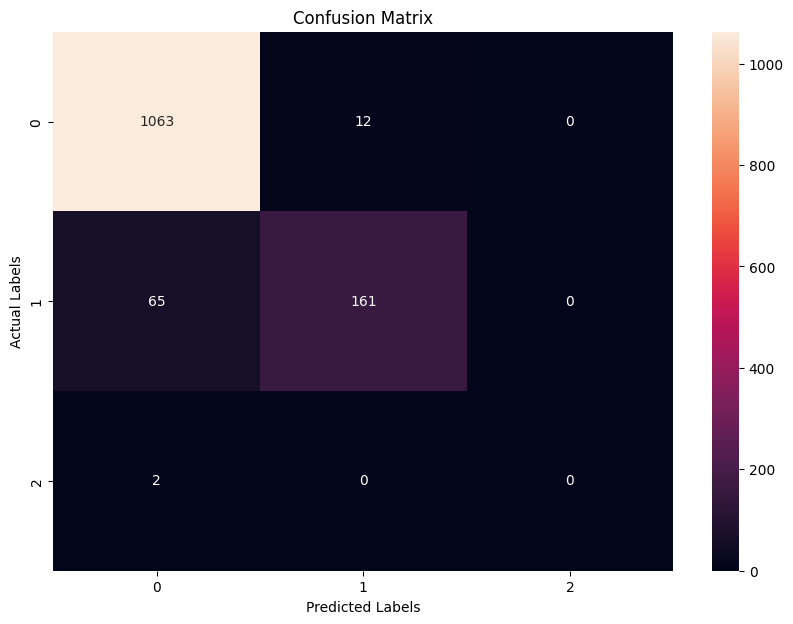

Classification Report:
               precision    recall  f1-score   support

     aerobic       0.94      0.99      0.96      1075
   anaerobic       0.93      0.71      0.81       226
    conflict       0.00      0.00      0.00         2

    accuracy                           0.94      1303
   macro avg       0.62      0.57      0.59      1303
weighted avg       0.94      0.94      0.94      1303

Cross-Validation Scores: [0.9488491  0.93861893 0.91304348 0.94102564 0.94358974]


C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

In [12]:
# Evaluating the fit of the model
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

#  Evaluating Y_test vs Y_pred
# Accuracy Score
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)


# Different confusion matrix test
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


# Classification Report
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:\n", class_report)

# Cross validation scores:
print("Cross-Validation Scores:", scores)

Confusion matrix, without normalization
[[1063   12    0]
 [  65  161    0]
 [   2    0    0]]
Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.29 0.71 0.  ]
 [1.   0.   0.  ]]


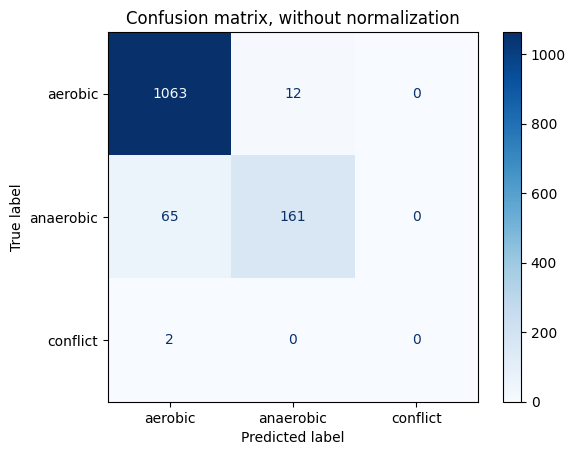

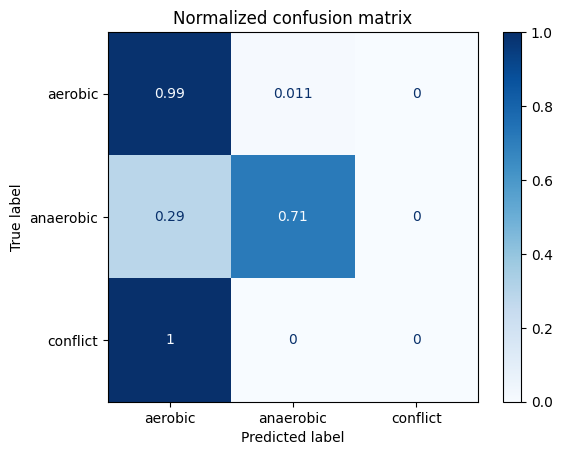

In [13]:
np.set_printoptions(precision=2)

# Plots non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()